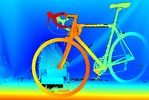

https://vision.middlebury.edu/stereo/data/scenes2014/


2008


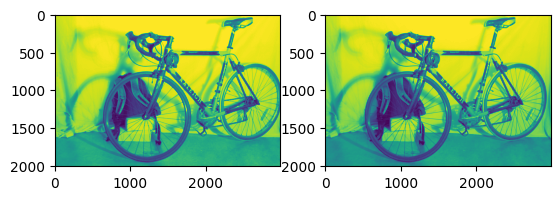

In [3]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

img1 = cv2.imread('im0.png',0) #queryimage # left image
img2 = cv2.imread('im1.png',0) #trainimage # right image
print(img1.shape[0])
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)
plt.show()


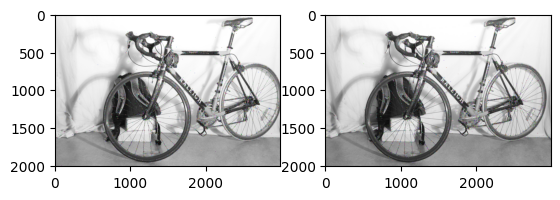

In [ ]:
sift = cv.SIFT_create()

#Encuentra los puntos clave y descriptores con SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

img11=cv.drawKeypoints(img1,kp1,img1)
img21=cv.drawKeypoints(img2,kp2,img2)

plt.subplot(121),plt.imshow(img11)
plt.subplot(122),plt.imshow(img21)
plt.show()

#BFMatcher and FlannBasedMatcher, both used for feature matching in computer vision.
#These matchers are often used in computer vision tasks like object recognition, image stitching, 
#or other applications where finding correspondences between keypoints in images is necessary.

bf = cv2.BFMatcher() #BFMatcher:Brute Force Matcher. 

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params) #FlannBasedMatcher:Fast Library for Approximate Nearest Neighbors (FLANN) based Matcher. 


matches = flann.knnMatch(des1,des2,k=2)

def print_goodmatches(matches):
    # Extract good matches by applying ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # Adjust the ratio threshold as needed
            good_matches.append(m)
    
    # Print the matches
    for match in good_matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
    
        # Print the indices of matched keypoints in both images
        print(f"Matched keypoints: Image 1 - {img1_idx}, Image 2 - {img2_idx}")

#print_goodmatches(matches)

f= 5299.313
width=2988
height=2008
doffs=174.186
baseline=177.288 #in mm
ndisp=180

def score_feature_match(descriptor1, descriptor2):
    if descriptor1 is None or descriptor2 is None:
        return np.inf  # Return a high score if either descriptor is missing

    distance = np.linalg.norm(descriptor1 - descriptor2)

    return distance


def get_feature_descriptor(I1, x, y):
    keypoints, descriptors = sift.detectAndCompute(I1, None)
    for kp in keypoints:
        if int(kp.pt[0]) == x and int(kp.pt[1]) == y:
            return descriptors[keypoints.index(kp)]

    return None

def compute_depth(I1, I2, dx, f):
    depth = np.zeros((I1.shape[0],I1.shape[1]), dtype=np.uint8)
    
    for i in range(I1.shape[0]):  # Loop through rows of I1
        for j in range(I1.shape[1]):  # Loop through columns of I1
            fij = get_feature_descriptor(I1, i, j)
            best_score = np.inf
            best_i = np.nan
            
            for i_prime in range(I2.shape[1]):  # Loop through columns of I2
                fi_prime_j = get_feature_descriptor(I2, i_prime, j)
                score = score_feature_match(fij, fi_prime_j)
                
                if score < best_score:
                    best_score = score
                    best_i = i_prime
            
            depth[i, j] = f * dx / (i - best_i)
    
    return depth 
    
compute_depth(img1, img2, baseline, f)

In [ ]:
plt.subplot(121),plt.imshow((z)/(np.max(z))*255,'gray')
plt.show
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

disparity = stereo.compute(img1,img2)

plt.subplot(122), plt.imshow(disparity,'gray')
plt.show

